In [1]:
import torch
from torch.nn import functional as F
import sys
sys.path.append('..')
import helper

batch_size, num_steps = 32, 35
train_iter, vocab = helper.Loader.load_data_time_machine(batch_size, num_steps)

In [2]:
num_hiddens = 256
rnn_layer = torch.nn.RNN(len(vocab), num_hiddens)
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [3]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X,state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [4]:
class RNNModel(torch.nn.Module):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = rnn_layer.hidden_size
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.liner = torch.nn.Linear(num_hiddens, vocab_size)
        else:
            self.num_directions = 2
            self.liner = torch.nn.Linear(num_hiddens * 2, vocab_size)
    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        output = self.liner(Y.reshape((-1, Y.shape[-1])))
        return output, state
    def begin_state(self, device, batch_size = 1):
        if not isinstance(self.rnn, torch.nn.LSTM):
            return torch.zeros((self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens), device=device)
        else:
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [5]:
device = helper.GPU.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
helper.predict_ch8('time traveller', 10, net, vocab, device)

'time travellerwwwwwwwwww'

time traveller the the the the the the the the the the the the t
time traveller the the the the the the the the the the the the t
time traveller and he sion the the the the the the the the the t
time traveller the the the the the the the the the the the the t
time traveller and and there and the thene dimensions of space a
time traveller the this the this this this thith sime the this t
time traveller time thaveller timentisnolly it the rimentimns in
time traveller thice dimensiont at one that we thatel the tion w
time traveller the end an ansedle than at al ond an an in time t
time traveller for athis to thay th se aimers of and stine time 
time traveller filentifn bs fot in the time traveller three dime
time traveller but now you sail filby bo ascilbyestou shace hove
time traveller ffre there whing this thet thise allred the time 
time traveller this is thay il and the treel ass ofot s allint o
time traveller ould and anot stid filbyoc the of the sthes ofist
time traveller thrdeid t 

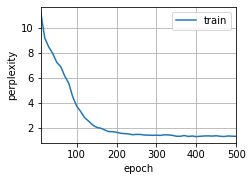

In [6]:
num_epochs, lr = 500, 1
helper.train_ch8(net, train_iter, vocab, lr, num_epochs, device)